In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Before we start, we will upload a dataset. It will consist of 2000 photos of cats and dogs in the trayne and 1000 in the test. 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

After unpacking, the data has the following structure:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>


In [3]:
# define data folders
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [4]:
num_cats_tr = len(list(train_cats_dir.glob("*"))) # .glob("*") creates an iterator over all files in the directory
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [5]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Let's take a look at some pictures with our eyes

(499, 459, 3)
(339, 200, 3)


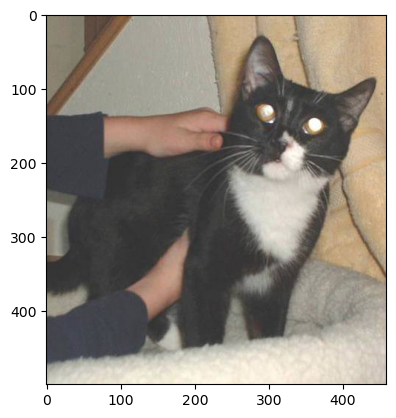

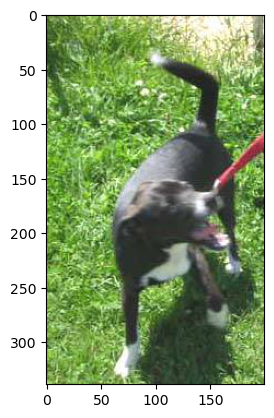

In [6]:
image_path = str(list(validation_cats_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

image_path = str(list(validation_dogs_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

To proceed further, we need to implement code that does the following:

1.  Reads the picture from the disk
2.  Resizes it to a predetermined size (IMAGE_SIZE, IMAGE_SIZE)
3.  Normalizes the pixel values (by dividing by 255)
4.  Once the BATCH_SIZE of the pictures has been read -- turn it into a four-dimensional size tensor (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3) and feed it into the network input along with its corresponding classes.

Translated with www.DeepL.com/Translator (free version)

In [7]:
BATCH_SIZE = 100 #  batch size -- i.e., the number of images we read at a time
IMG_SHAPE  = 150 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ImageDataGenerator?

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
recommended for new code. Prefer loading images with
`tf.keras.utils.image_dataset_from_directory` and transforming the output
`tf.data.Dataset` with preprocessing layers. For more information, see the
tutoria

we are interested in the *rescale* parameter. It is responsible for normalizing pixel values, namely multiplying them by a number -- in our case 1./255

Let's define generators for trayne and validation:

In [9]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255) 

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=train_dir, # trainer folder path
                                                            shuffle=True,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                            class_mode='binary') # т.к. у нас два класса можем воспользоваться binary

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir, # validation folder path
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [12]:
type(train_data_gen)

keras.src.preprocessing.image.DirectoryIterator

In [13]:
sample_training_images, sample_labels = next(train_data_gen) # as soon as we execute this command, we'll count 100 pictures from the disk
                                                              # and convert them to the proper format

sample_training_images.shape, sample_labels.shape # 4x dimensional tensor and vector of class labels

((100, 150, 150, 3), (100,))

In [14]:
sample_labels

array([1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [15]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

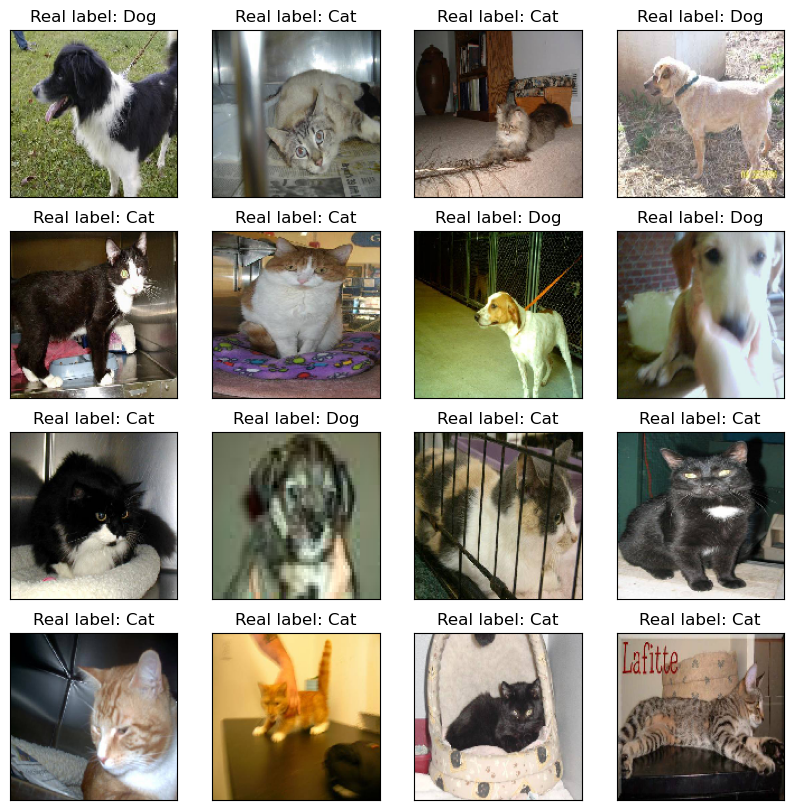

In [16]:
show_catsdogs(sample_training_images, sample_labels)
sample_training_images, sample_labels = next(train_data_gen)

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                activation='relu', input_shape=(150, 150, 3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2)) # halving 

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [18]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=int(total_train / BATCH_SIZE), 
                    epochs=10, 
                    validation_data=val_data_gen, 
                    validation_steps=int(total_val / BATCH_SIZE))

Epoch 1/10


20/20 [==============================] - 39s 2s/step - loss: 0.7117 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 32s 2s/step - loss: 0.6920 - accuracy: 0.5375 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 31s 2s/step - loss: 0.6924 - accuracy: 0.5215 - val_loss: 0.6856 - val_accuracy: 0.6010
Epoch 4/10
20/20 [==============================] - 29s 1s/step - loss: 0.6831 - accuracy: 0.5675 - val_loss: 0.6825 - val_accuracy: 0.5370
Epoch 5/10
20/20 [==============================] - 31s 2s/step - loss: 0.6738 - accuracy: 0.5875 - val_loss: 0.6770 - val_accuracy: 0.5690
Epoch 6/10
20/20 [==============================] - 31s 2s/step - loss: 0.6530 - accuracy: 0.6340 - val_loss: 0.6252 - val_accuracy: 0.6640
Epoch 7/10
20/20 [==============================] - 30s 1s/step - loss: 0.6028 - accuracy: 0.6790 - val_loss: 0.6919 - val_accuracy: 0.5900
Epoch 8/10
20/20 [

In [21]:
from livelossplot.tf_keras import PlotLossesCallback

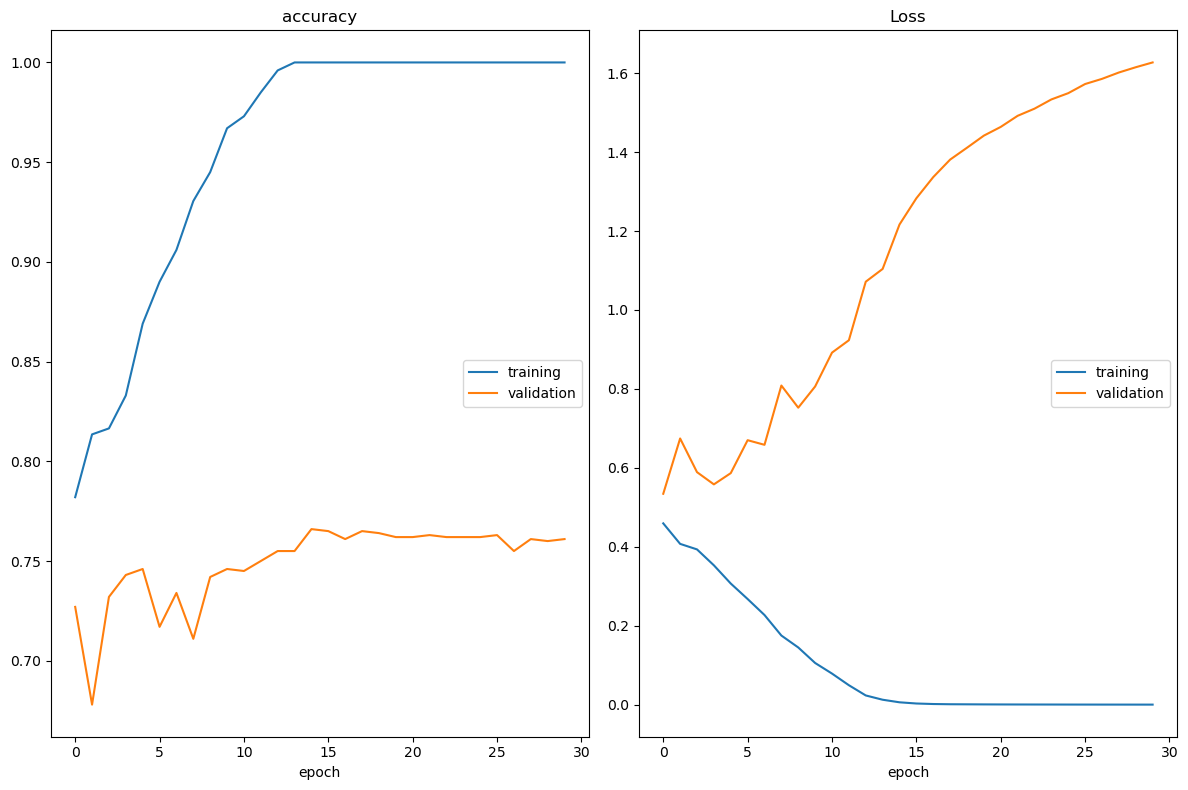

accuracy
	training         	 (min:    0.782, max:    1.000, cur:    1.000)
	validation       	 (min:    0.678, max:    0.766, cur:    0.761)
Loss
	training         	 (min:    0.000, max:    0.459, cur:    0.000)
	validation       	 (min:    0.534, max:    1.627, cur:    1.627)
20/20 [==============================] - 29s 1s/step - loss: 2.1945e-04 - accuracy: 1.0000 - val_loss: 1.6272 - val_accuracy: 0.7610


In [22]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

Based on the results of model training, the following conclusions can be drawn:

Accuracy (Accuracy):

On the training set, the maximum accuracy of 100% is achieved.
On the validation set the accuracy is 76%.
Loss (Loss):

On the training set, the losses are minimal and close to zero.
On the validation set the loss is 1.697.
Conclusion:

The model exhibits overtraining as the gap between the accuracy on training and validation is significant.
It is recommended to apply regularization techniques such as dropout and increase the diversity of training data.
Optimization of model parameters and structure may lead to better results.

## Apply transfer learning and fine-tuning to the familiar task of classifying cats and dogs!

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # specify preprocessing_function !!!
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                      directory=train_dir,
                                                      shuffle=True,
                                                      target_size=(IMG_SHAPE,IMG_SHAPE),
                                                      class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [25]:
IMG_SHAPE = (150, 150, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

base_model.trainable = False # freeze the entire base model
base_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [26]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [28]:
from livelossplot.tf_keras import PlotLossesCallback

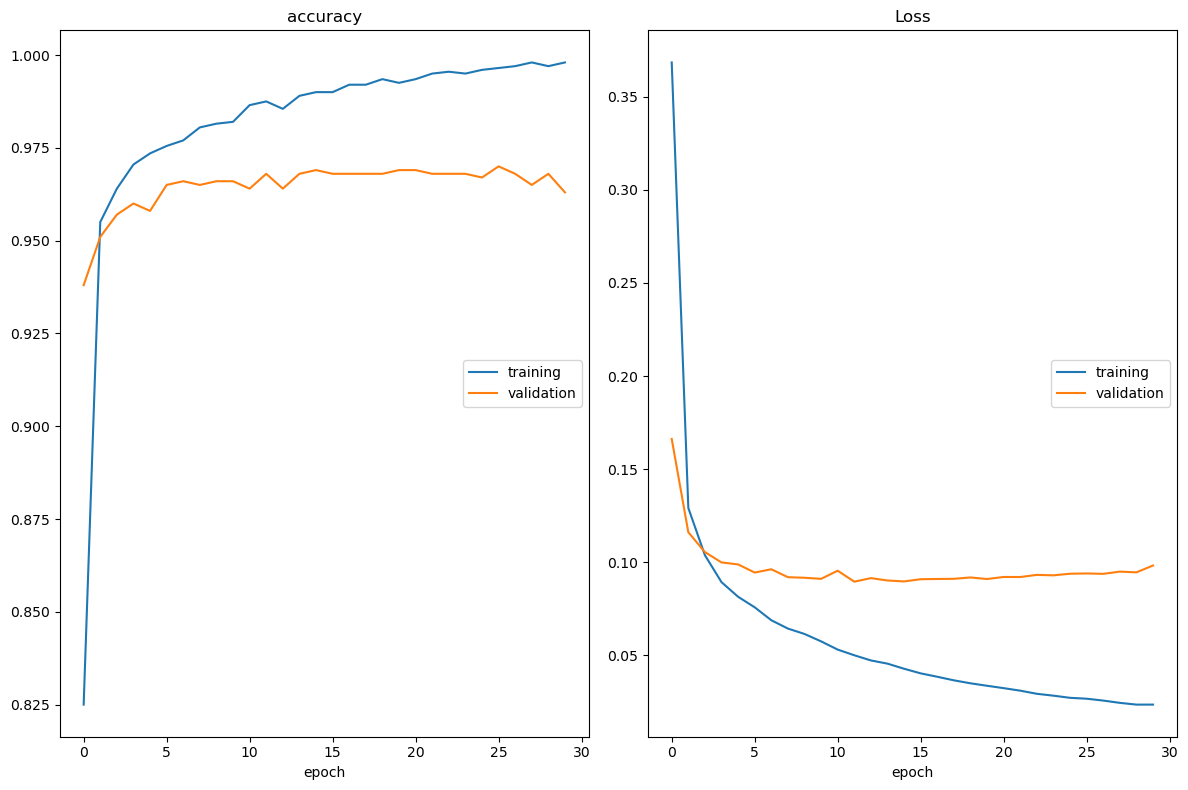

accuracy
	training         	 (min:    0.825, max:    0.998, cur:    0.998)
	validation       	 (min:    0.938, max:    0.970, cur:    0.963)
Loss
	training         	 (min:    0.024, max:    0.368, cur:    0.024)
	validation       	 (min:    0.090, max:    0.166, cur:    0.098)
20/20 [==============================] - 19s 975ms/step - loss: 0.0236 - accuracy: 0.9980 - val_loss: 0.0982 - val_accuracy: 0.9630


In [29]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])